${\Huge \text{GroupFold Cross Validation - driver classification}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook aims to perform rigorous cross-validation by testing the model (fixed algorithm, fixed set of features) on mutations (or patients) that have never been seen in the training set, and then compare the performance differences with a basic cross-validation.

This notebook is divided in 4 parts:
* **1. Baseline**
* **2. GroupKFold with `group = mut_key`**
* **3. GroupKFold with `group = patient_key`**
* **4. Summary**

***

In [1]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Selene_Job.cluster_username             = 'guilminp'
Selene_Job.ssh_remote_jobs_cluster_path = '/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs'
Selene_Job.ssh_remote_jobs_local_path   = 'ssh_remote_jobs'

Setup environment... done!


<span style="color:green">✅ Working on **imp-ann_env** conda environment.</span>

# Baseline

In [4]:
data = Impact_Wrapper('../../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_driver')

In [5]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
            'gene_type', 'VEP_SIFT_class', 'VEP_PolyPhen_class']

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (218173, 54) | y: (218173,)


,count_,freq_
False,140321,64.32%
True,77852,35.68%


In [6]:
job_baseline = Selene_Job('gkf_baseline')
job_baseline.load_data(X, y)

<span style="color:red">Job < gkf_baseline >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_baseline


<span style="color:green">Job < gkf_baseline >: </span>✅ data loaded

In [2]:
job_baseline = Selene_Job('gkf_baseline', load_from_id=True)

<span style="color:green">Job < gkf_baseline >: </span>✅ job found and reloaded

In [8]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=18, criterion='entropy'))
metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_gkf_baseline/script.ipy


In [9]:
job_baseline.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_gkf_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_baseline
script.ipy                                    100%  861     9.2KB/s   00:00    
X.pkl                                         100%   53MB  10.6MB/s   00:05    
y.pkl                                         100% 3623KB   7.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_baseline
Job <31457673> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_baseline -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < gkf_baseline >: </span>✅ submitted<br>

In [4]:
job_baseline.get_results()

<span style="color:green">Job < gkf_baseline >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_baseline to ssh_remote_jobs/job_gkf_baseline
metrics.pkl                                   100%   73MB   3.4MB/s   00:21    
job_output.txt                                100% 1529   396.5KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.983 ± 0.001
▴ Mean roc_auc          : 0.987 ± 0.001
▴ Mean precision        : 0.949 ± 0.003
▴ Mean recall           : 0.922 ± 0.002
▴ Mean f1               : 0.935 ± 0.002
▴ Mean accuracy         : 0.954 ± 0.001


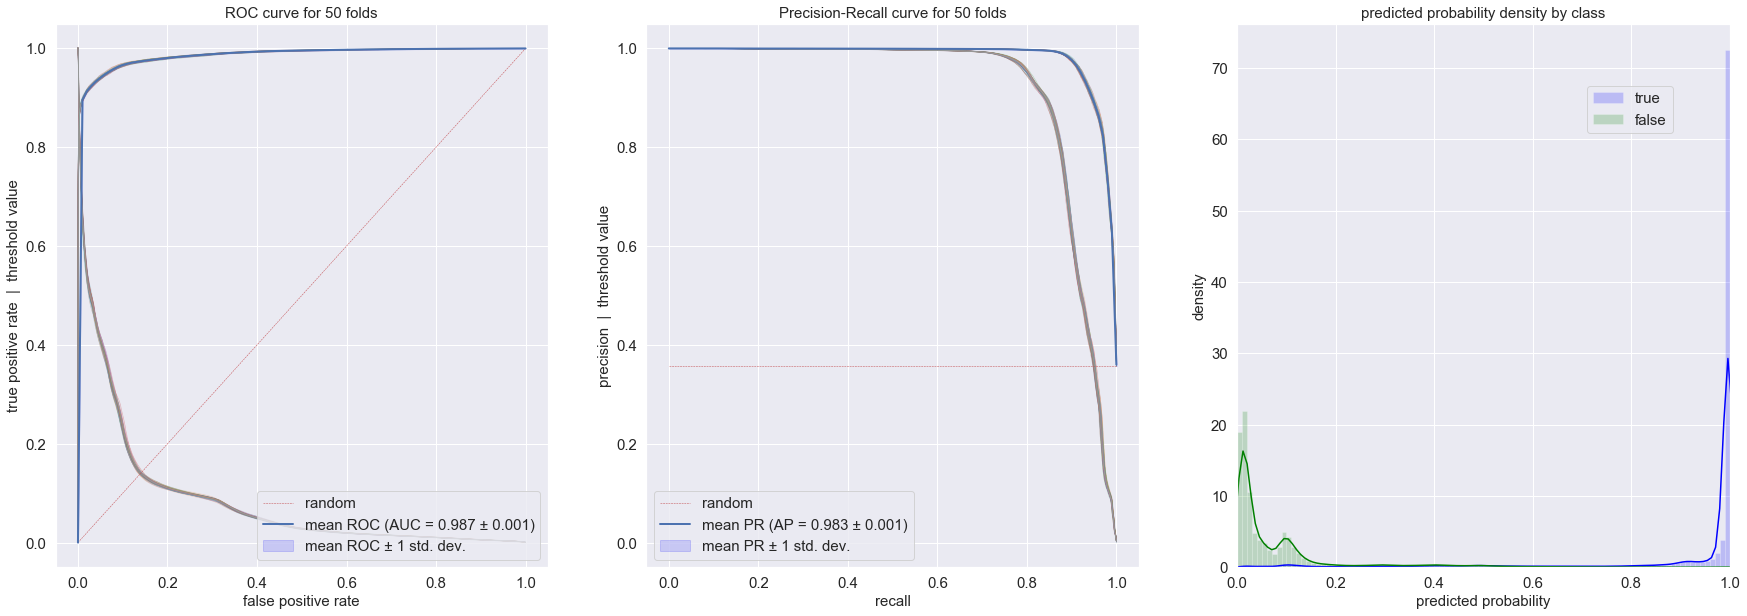

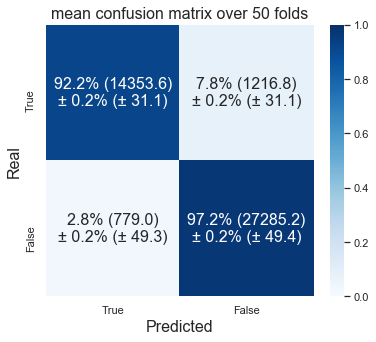

In [5]:
job_baseline.metrics.print_mean()
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_baseline.metrics.plot_mean_confusion_matrix()

# GroupKFold with group = `mut_key`

In [10]:
group_mut_key = data.get_original_impact()['mut_key']

In [11]:
job_mut_key = Selene_Job('gkf_mut_key')
job_mut_key.load_data(X, y, groups=group_mut_key)

<span style="color:red">Job < gkf_mut_key >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_mut_key
➞ save groups.pkl in ssh_remote_jobs/job_gkf_mut_key


<span style="color:green">Job < gkf_mut_key >: </span>✅ data loaded

In [6]:
job_mut_key = Selene_Job('gkf_mut_key', load_from_id=True)

<span style="color:green">Job < gkf_mut_key >: </span>✅ job found and reloaded

In [13]:
%%writefile {job_mut_key.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
groups = pd.read_pickle('groups.pkl')

# set cross-validation
from sklearn.model_selection import GroupKFold
cv_strategy = GroupKFold(n_splits=5)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=18, criterion='entropy'))
metrics = Metrics(model, X, y, cv_strategy, groups=groups, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_gkf_mut_key/script.ipy


In [14]:
job_mut_key.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_gkf_mut_key to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_mut_key
groups.pkl                                    100% 6556KB   6.4MB/s   00:00    
script.ipy                                    100%  857    22.5KB/s   00:00    
X.pkl                                         100%   53MB   7.6MB/s   00:07    
y.pkl                                         100% 3623KB   7.9MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_mut_key
Job <31457720> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_mut_key -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < gkf_mut_key >: </span>✅ submitted<br>

In [7]:
job_mut_key.get_results()

<span style="color:green">Job < gkf_mut_key >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_mut_key to ssh_remote_jobs/job_gkf_mut_key
metrics.pkl                                   100% 7527KB   3.1MB/s   00:02    
job_output.txt                                100% 1521   134.2KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.978 ± 0.001
▴ Mean roc_auc          : 0.984 ± 0.001
▴ Mean precision        : 0.944 ± 0.004
▴ Mean recall           : 0.910 ± 0.005
▴ Mean f1               : 0.927 ± 0.003
▴ Mean accuracy         : 0.949 ± 0.002


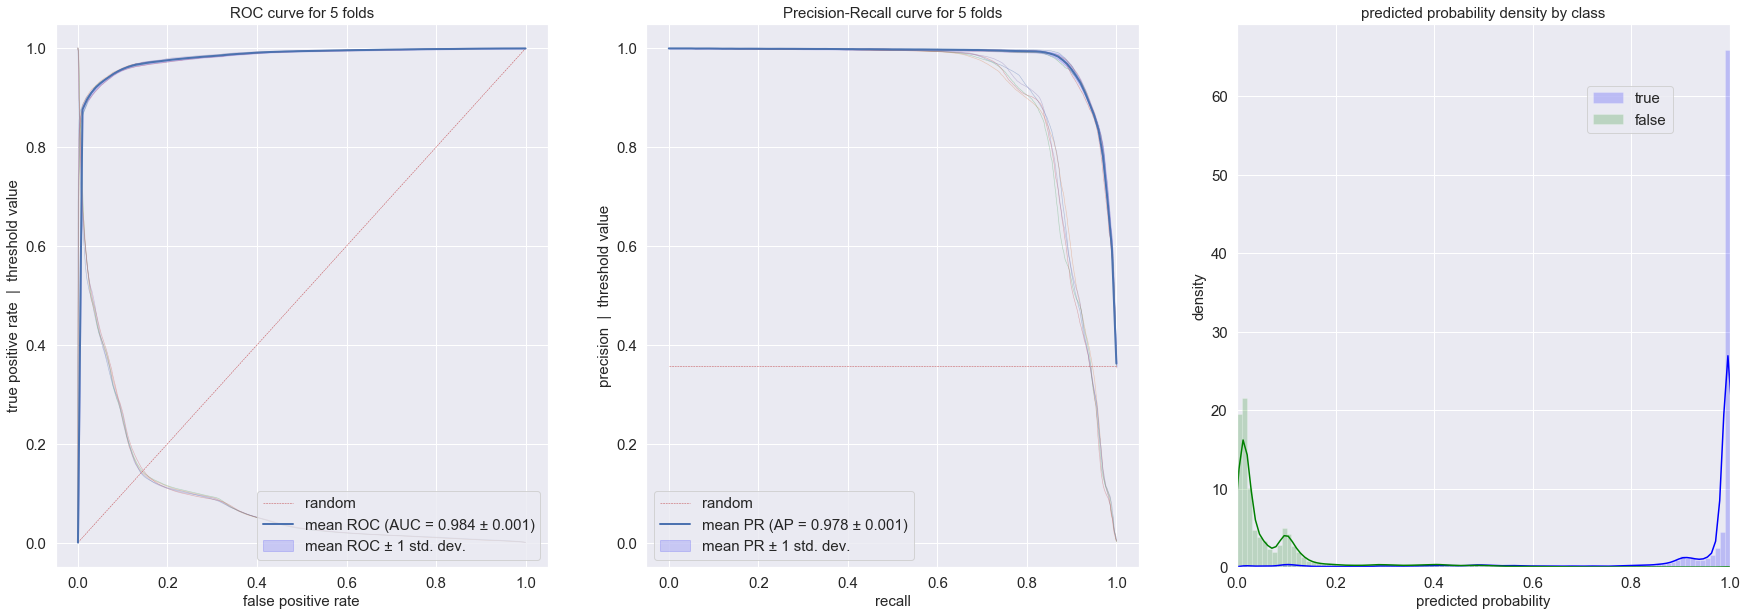

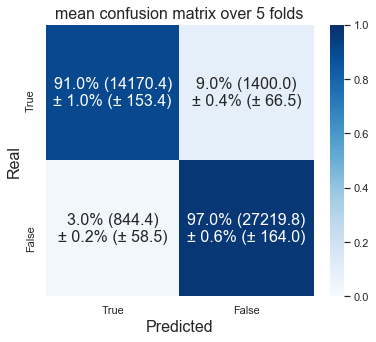

In [8]:
job_mut_key.metrics.print_mean()
job_mut_key.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_mut_key.metrics.plot_mean_confusion_matrix()

# GroupKFold with group = `patient_key`

In [15]:
group_patient_key = data.get_original_impact()['patient_key']

In [16]:
job_patient_key = Selene_Job('gkf_patient_key')
job_patient_key.load_data(X, y, groups=group_patient_key)

<span style="color:red">Job < gkf_patient_key >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_patient_key
➞ save groups.pkl in ssh_remote_jobs/job_gkf_patient_key


<span style="color:green">Job < gkf_patient_key >: </span>✅ data loaded

In [9]:
job_patient_key = Selene_Job('gkf_patient_key', load_from_id=True)

<span style="color:green">Job < gkf_patient_key >: </span>✅ job found and reloaded

In [18]:
%%writefile {job_patient_key.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
groups = pd.read_pickle('groups.pkl')

# set cross-validation
from sklearn.model_selection import GroupKFold
cv_strategy = GroupKFold(n_splits=5)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=18, criterion='entropy'))
metrics = Metrics(model, X, y, cv_strategy, groups=groups, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_gkf_patient_key/script.ipy


In [19]:
job_patient_key.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_gkf_patient_key to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_patient_key
groups.pkl                                    100% 4609KB   5.1MB/s   00:00    
script.ipy                                    100%  857    13.3KB/s   00:00    
X.pkl                                         100%   53MB   7.6MB/s   00:07    
y.pkl                                         100% 3623KB   8.5MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_patient_key
Job <31457762> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_patient_key -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < gkf_patient_key >: </span>✅ submitted<br>

In [10]:
job_patient_key.get_results()

<span style="color:green">Job < gkf_patient_key >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_patient_key to ssh_remote_jobs/job_gkf_patient_key
metrics.pkl                                   100% 7523KB   2.9MB/s   00:02    
job_output.txt                                100% 1533   420.2KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.983 ± 0.001
▴ Mean roc_auc          : 0.987 ± 0.001
▴ Mean precision        : 0.949 ± 0.003
▴ Mean recall           : 0.922 ± 0.002
▴ Mean f1               : 0.935 ± 0.001
▴ Mean accuracy         : 0.954 ± 0.001


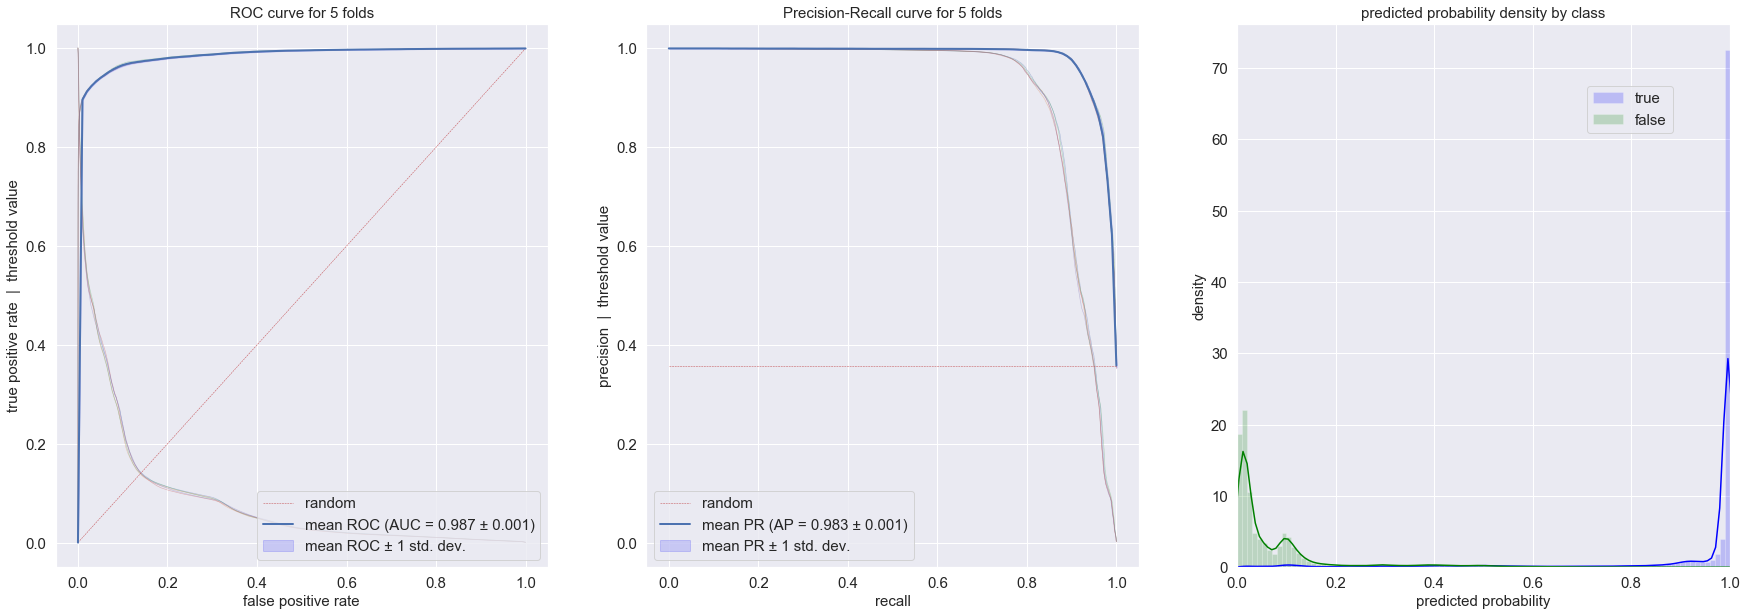

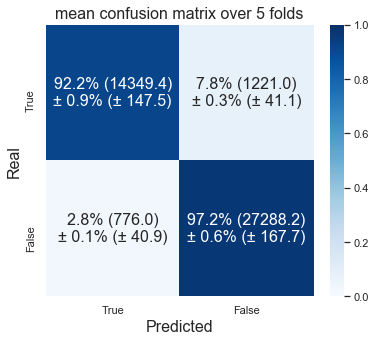

In [11]:
job_patient_key.metrics.print_mean()
job_patient_key.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_patient_key.metrics.plot_mean_confusion_matrix()

# Summary

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.983,0.987,0.949,0.922,0.935,0.954
mut_key,0.978,0.984,0.944,0.91,0.927,0.949
patient_key,0.983,0.987,0.949,0.922,0.935,0.954


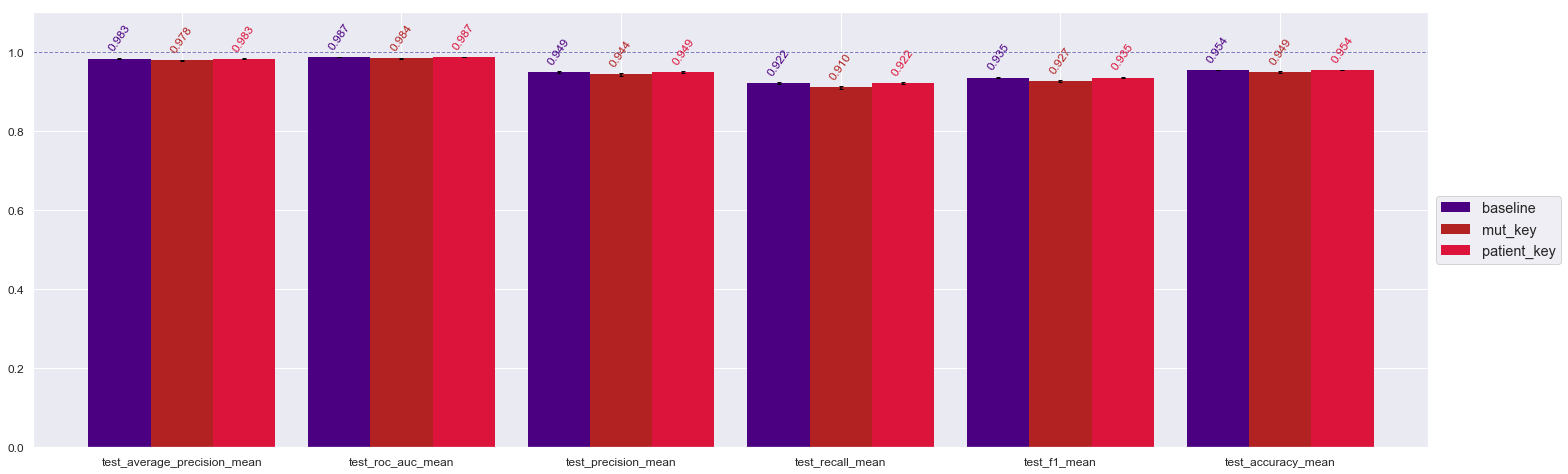

In [29]:
summary = Summary()
summary.add(job_baseline.metrics   , 'baseline'   , 'indigo')
summary.add(job_mut_key.metrics    , 'mut_key'    , 'firebrick')
summary.add(job_patient_key.metrics, 'patient_key', 'crimson')
summary.display()
summary.plot()